In [11]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.stats import wasserstein_distance
from statsmodels.distributions.empirical_distribution import ECDF
import datetime
import seaborn as sns
import math
import random
from numpy import exp
#import pyreadstat

from scipy.optimize import curve_fit

import json

#Avoiding Type 3 fonts in matplotlib plots
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'Arial'

In [12]:
font = {'size'   : 15}

matplotlib.rc('font', **font)
matplotlib.rc('lines', linewidth=2.0)
matplotlib.rc('lines', markersize=8)

In [13]:
res='results_mobility/'

# Datasets Reading

### MiD Data 2017
Mobilität in Deutschland

The loading of this data set requires you to have acquired the MiD 2017 data, which is not public and must be requested via https://daten.clearingstelle-verkehr.de/order-form.html .
Only execute these code blocks in case you acquired the data set.

In [4]:
# data reading
'''
wegkm: wegelänge, path length
hvm: hauptverkehrsmittel, main mode of transport
hvm_diff2: hauptverkehrsmittel (stärker differenziert), more differentiated

'''
df_MiD=pd.read_csv('../data/MiD2017_Wege.csv',decimal=',',sep=';',usecols=['wegkm','hvm','hvm_diff2','W_ZWECK','ST_JAHR','ST_MONAT'])
print(df_MiD.shape)
#exclude unwanted lines with "unknown" distance value et al
df_MiD=df_MiD[df_MiD.wegkm.isin([9994,9999,70703]) == False]
df_MiD.head(3)

(960619, 6)


,ST_MONAT,ST_JAHR,W_ZWECK,wegkm,hvm,hvm_diff2
0,3,2017,1,21.85,4,9
1,3,2017,5,0.39,1,1
2,3,2017,8,21.85,4,9


In [5]:
# Different transport modes extraction
df_MiD_walk =df_MiD[df_MiD.hvm.isin([1]) == True] # Walk
df_MiD_bike = df_MiD[df_MiD.hvm.isin([2]) == True] # Bicycle (incl. Ebike)
df_MiD_autopass = df_MiD[df_MiD.hvm.isin([3]) == True] # Auto Passengers
df_MiD_autodriver = df_MiD[df_MiD.hvm.isin([4]) == True] # Auto Drivers

df_MiD_public=df_MiD[df_MiD.hvm.isin([5]) == True] #public
# Public Transport w/o long distance vehicles,short range
df_MiD_SRpublic=df_MiD_public[df_MiD_public.hvm_diff2.isin([19,20,21,22,23])==False] 
# long range
df_MiD_LRpublic=df_MiD_public[df_MiD_public.hvm_diff2.isin([20,21,22,23])==True] 

### NHTS17 Data
American travel and trip data

The data is public and can be acquired via https://nhts.ornl.gov/downloads
The relevant file is `trippub.csv`

In [45]:
# data reading
# TRPMILES: Trip distance in miles, derived from route geometry returned
# TRPTRANS: Trip Mode, derived 
# WHYTRP1S: Trip purpose summary
df_Nhts=pd.read_csv('data/trippub_2017NHTS.csv',decimal='.',sep=',',usecols=["TRPMILES", "TRPTRANS","WHYTRP1S"])
print(df_Nhts.shape)
df_Nhts.head(3)

(923572, 3)


,TRPMILES,TRPTRANS,WHYTRP1S
0,5.244,3,20
1,5.149,3,1
2,84.004,6,1


In [46]:
# Filter the data set by transport modes and convert trip lengths from miles to kilometers

df_Nhts_walk =df_Nhts['TRPMILES'][df_Nhts.TRPTRANS.isin([1]) == True]*1.60934 # Walk and transform to km
df_Nhts_bike = df_Nhts['TRPMILES'][df_Nhts.TRPTRANS.isin([2]) == True]*1.60934 # Bicycle and transform to km
#3auto 4suv 5van 6 pick up truck 18rentalcar
df_Nhts_auto=df_Nhts['TRPMILES'][df_Nhts.TRPTRANS.isin([3,4,5,6,18])==True]*1.60934   #Auto
# Public Transport short distance
#10school bus, 11public bus, 12paratransit / dial-a-ride, 13private/charter/tour/shutnhtse bus, 15amtrack / commuter rail, 16subway, 17taxi /limo (incl uber)
df_Nhts_SRpublic=df_Nhts['TRPMILES'][df_Nhts.TRPTRANS.isin([10,11,12,13,16,17])==True]*1.60934  
# long distance public transport
#14City-to-city bus (Greyhound, Megabus), 19Airplane, 20Boat/ferry/water taxi
df_Nhts_LRpublic=df_Nhts['TRPMILES'][df_Nhts.TRPTRANS.isin([14,19,20])==True]*1.60934  

# Power-law trend in short- and medium-distance trips

In this section, we fit the CCDF of a power-law trend $f(x) = C \cdot x^{-(\alpha-1)}$ to the CCDF of our emperical data.

We only fit this trend towards a certain range of the data, which showed a linear trend in a  log-log plot

In [47]:
'''
There are a total of 4 sub-datasets, 3 of which have been annotated for successful execution of the script,
If you want to see the other datasets, uncomment them accordingly.

- Walking in MiD 2017
- MiD Driving 2017
- NHTS Driving 2017
- NHTS Short-Distance Public Transport 2017
'''

# ----- Walking in MiD 2017
#df_vec=df_MiD_walk['wegkm'].copy() 
#t_err_min_distance=2.9  
#t_err_max_distance=30 
# select the data trips between min and max distance to have a nicer observation
#min_distance=1
#max_distance=100

# ----- MiD Driving
# df_vec=df_MiD_autodriver['wegkm'].copy() # Auto Driver in MiD 2017
# t_err_min_distance=20
# t_err_max_distance=200
# min_distance=10
# max_distance=500

# ----- NHTS Driving 
df_vec=df_Nhts_auto.copy() #Auto Driver in Nhts 17

# The following two values give the start and end of the
# power-law trend. We identified them manually by locating a 
# linear trend in the log-log CCDF of the data 
t_err_min_distance=20 
t_err_max_distance=200

# Limits the considered emperical data to a certain range of distances
min_distance=10
max_distance=500


# -----  NHTS Short-Distance Public Transport
# df_vec=df_Nhts_SRpublic.copy() #Short range public in Nhts17 
# t_err_min_distance=20
# t_err_max_distance=500
# # select the data between min distance 10km and max distance 1000km
# min_distance=10
# max_distance=1000

df_vec=df_vec[df_vec.between(min_distance,max_distance)]

In [48]:
'''
Returns the y-value of a given point x in the CCDF of the emperical data
'''
def cal_y_ccdf(data,x):
    
    sorted_data = np.sort(data)
    linspaced = np.linspace(0, 1, len(data), endpoint=False)
    y=1-linspaced
    
    return np.interp(x, sorted_data,y)

To find values of $C$ and $\alpha$ that fit the trend $F(x) = C/x^{\alpha-1}$ observed between `x_1 = t_err_min_distance` and `x_2= t_err_min_distance`, we analytically solve for values such that $F(x_1) = y_1$ and $F(x_2) = y_2$.
The values of $y_1$ and $y_2$ describe the values of the emperical CCDF at points $x_1$ and $x_2$, respectively.

In [49]:
X1=t_err_min_distance
X2=t_err_max_distance
Y1=cal_y_ccdf(df_vec,X1)
Y2=cal_y_ccdf(df_vec,X2)

alp=(math.log(Y1)-math.log(Y2))/(math.log(X2)-math.log(X1)) + 1
C=Y1*(X1**(alp-1))

In [50]:
''' Plot the CCDF

data: the dataset used to plot the ccdf
lb: name of the dataset (for labelling purposes)
X1,X2: start and end of the power-law trend
C: calculated value of C
Alp: calculated value of alpha 

'''

def ccdf_draw(data,lb,X1,X2,C,alp):
    fig, ax = plt.subplots(figsize=(3.54*1.5,2.83*1.5))
        
    sorted_data = np.sort(data)
    linspaced = np.linspace(0, 1, len(data), endpoint=False)
    ax.plot(sorted_data, 1-linspaced,label='Empirical data',rasterized=False,markersize=5,alpha=0.8,linewidth=5)

    # Number of samples to generate
    num_samples=20
    # 100 linearly spaced numbers
    s = np.linspace(X1,X2,num_samples)
    # the function
    t = C/(s**(alp-1))
    
    # plot the function
    ax.plot(s,t, 'r',linewidth=6,label='Power-law')
        
    plt.xlabel('Trip Length (km)')
    plt.ylabel('CCDF')
    leg = ax.legend(title=lb,loc='lower left',alignment='left')
    leg.get_title().set_fontsize('15')

    plt.yscale("log")
    plt.xscale("log")
    plt.grid()
    plt.show()


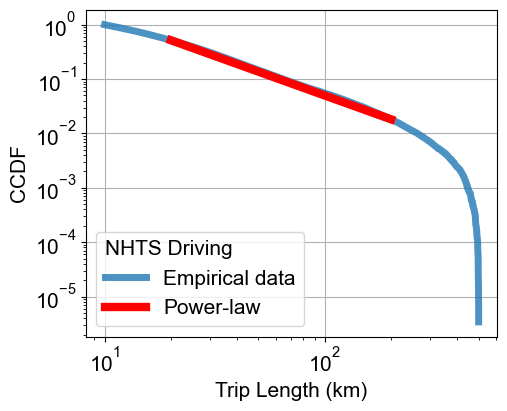

In [51]:
# ccdf_draw(df_vec,'MiD Walking',X1,X2,C,alp)
# ccdf_draw(df_vec,'MiD Driving',X1,X2,C,alp)
ccdf_draw(df_vec,'NHTS Driving',X1,X2,C,alp)
# ccdf_draw(df_vec,'NHTS Short-Distance\nPublic Transport',X1,X2,C,alp)